In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.maxent_irl_gridworld import main, run_maxent_irl

PARSER = argparse.ArgumentParser(description=None)
PARSER.add_argument('-hei', '--height', default=5, type=int, help='height of the gridworld')
PARSER.add_argument('-wid', '--width', default=5, type=int, help='width of the gridworld')
PARSER.add_argument('-g', '--gamma', default=0.8, type=float, help='discount factor')
PARSER.add_argument('-a', '--act_random', default=0.3, type=float, help='probability of acting randomly')
PARSER.add_argument('-t', '--n_trajs', default=100, type=int, help='number of expert trajectories')
PARSER.add_argument('-l', '--l_traj', default=20, type=int, help='length of expert trajectory')
PARSER.add_argument('--rand_start', dest='rand_start', action='store_true', help='when sampling trajectories, randomly pick start positions')
PARSER.add_argument('--no-rand_start', dest='rand_start',action='store_false', help='when sampling trajectories, fix start positions')
PARSER.set_defaults(rand_start=False)
PARSER.add_argument('-lr', '--learning_rate', default=0.01, type=float, help='learning rate')
PARSER.add_argument('-ni', '--n_iters', default=20, type=int, help='number of iterations')
PARSER.add_argument('-act', '--active', action='store_true', help='active learning setting')  # store true
PARSER.add_argument('-al', '--alpha', default=1.0, type=float, help='temperature parameter for value iteration')
PARSER.add_argument('-nq', '--n_query', default=1, type=int, help='number of queries to the expert(n_demonstrations)')
PARSER.add_argument('-rm', '--r_max', default=1, type=int, help='maximum reward value')
PARSER.add_argument('-er', '--error', default=0.01, type=float, help='error threshold for policy evaluation and value iteration')

def parse_args_str(args_str):
    args = PARSER.parse_args(args_str.split())
    return args

In [2]:
# active learning setting
args_str = """
--height 5
--width 5
--gamma 0.9
--act_random 0.3
--n_trajs 20
--l_traj 6
--learning_rate 0.01
--n_iters 100
--active
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
"""

args = parse_args_str(args_str)
print(args)
history_act = run_maxent_irl(args)

Namespace(height=5, width=5, gamma=0.9, act_random=0.3, n_trajs=20, l_traj=6, rand_start=False, learning_rate=0.01, n_iters=100, active=True, alpha=0.1, n_query=1, r_max=1, error=0.01)
[INFO] Initialize Grid World
[INFO] Getting ground truth values and policy via value teration
[INFO] Initialize trajectories
[INFO] Trajectory length(Include inital starting point) = 7, First trajectories.
[Step(cur_state=23, action=2, next_state=23, reward=0.0, done=False), Step(cur_state=23, action=2, next_state=24, reward=0.0, done=False), Step(cur_state=24, action=2, next_state=24, reward=1.0, done=False), Step(cur_state=24, action=0, next_state=24, reward=1.0, done=False), Step(cur_state=24, action=0, next_state=24, reward=1.0, done=False), Step(cur_state=24, action=0, next_state=24, reward=1.0, done=False), Step(cur_state=24, action=0, next_state=24, reward=1.0, done=False)]
[INFO] Start Learning
[INFO - 00001 ] Training MaxEnt IRL
iteration: 0/100
iteration: 5/100
iteration: 10/100
iteration: 15/1

In [11]:
np.abs(history_act['final']['values'] - history_act[0]['values_gt']).mean()

4.8945813184867815

In [3]:
# non-active learning setting
args_str = """
--height 5
--width 5
--gamma 0.9
--act_random 0.3
--n_trajs 20
--l_traj 6
--learning_rate 0.01
--n_iters 100
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
"""

args = parse_args_str(args_str)
print(args)
history_rand = run_maxent_irl(args)

Namespace(height=5, width=5, gamma=0.9, act_random=0.3, n_trajs=20, l_traj=6, rand_start=False, learning_rate=0.01, n_iters=100, active=False, alpha=0.1, n_query=1, r_max=1, error=0.01)
[INFO] Initialize Grid World
[INFO] Getting ground truth values and policy via value teration
[INFO] Initialize trajectories
[INFO] Trajectory length(Include inital starting point) = 7, First trajectories.
[Step(cur_state=23, action=2, next_state=23, reward=0.0, done=False), Step(cur_state=23, action=2, next_state=24, reward=0.0, done=False), Step(cur_state=24, action=2, next_state=24, reward=1.0, done=False), Step(cur_state=24, action=0, next_state=24, reward=1.0, done=False), Step(cur_state=24, action=0, next_state=24, reward=1.0, done=False), Step(cur_state=24, action=0, next_state=24, reward=1.0, done=False), Step(cur_state=24, action=0, next_state=24, reward=1.0, done=False)]
[INFO] Start Learning
[INFO - 00001 ] Training MaxEnt IRL
iteration: 0/100
iteration: 5/100
iteration: 10/100
iteration: 15/

In [7]:
np.abs(history_rand['final']['values'] - history_rand[0]['values_gt']).mean()

4.738578127836497

---

In [4]:
def get_infos(history):

    values_gt = history[0]['values_gt']
    policy_gt = history[0]['policy_gt']

    idxs = list(history.keys())[1:-1]
    all_values_diff = {'mean': [], 'std': []}
    for i in idxs:
        vd_mean = np.abs(history[i]['values'] - values_gt).mean()
        vd_std = np.abs(history[i]['values'] - values_gt).std()
        all_values_diff['mean'].append(vd_mean)
        all_values_diff['std'].append(vd_std)

    return all_values_diff

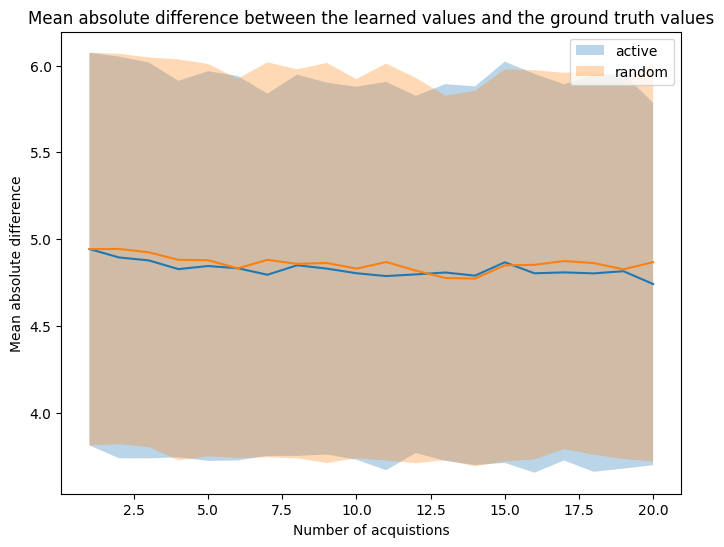

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

idxs_act = list(history_act.keys())[1:-1]
idxs_rand = list(history_rand.keys())[1:-1]
vd_act = get_infos(history_act)
vd_rand = get_infos(history_rand)

sns.lineplot(x=idxs_act, y=vd_act['mean'])
ax.fill_between(idxs_act, np.array(vd_act['mean']) - np.array(vd_act['std']),
                np.array(vd_act['mean']) + np.array(vd_act['std']), alpha=0.3, label='active')

sns.lineplot(x=idxs_rand, y=vd_rand['mean'])
ax.fill_between(idxs_rand, np.array(vd_rand['mean']) - np.array(vd_rand['std']),
                np.array(vd_rand['mean']) + np.array(vd_rand['std']), alpha=0.3, label='random')

ax.set_xlabel('Number of acquistions')
ax.set_ylabel('Mean absolute difference')
ax.set_title('Mean absolute difference between the learned values and the ground truth values')
ax.legend()
plt.show()